In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
from scipy.stats import kruskal

warnings.filterwarnings('ignore')

- Vou criar o modelo utilizando apenas os dados que não tiveram ruptura pois os valores das vendas são mais próximos dos reais

In [2]:
df = pd.read_csv('../../data/processed/dados_features_Intermittent.csv')
df['dt_estoque'] = pd.to_datetime(df['dt_estoque'])
df = df[df['is_ruptura']==0]
df.drop(columns=['tipo_demanda', 'qtd_venda_interp', 'is_ruptura', 'qt_estoque'], inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,key_loja,cod_produto,dt_estoque,qtd_vendas,des_estado_franquia,categoria_produto,sub_categoria_produto,linha_produto,vlr_venda_tabelado_mean,qtd_vendas_media_1d,...,max_7d_30d_ratio_qt_estoque,max_7d_60d_ratio_qt_estoque,max_30d_60d_ratio_qt_estoque,min_1d_7d_ratio_qt_estoque,min_1d_30d_ratio_qt_estoque,min_1d_60d_ratio_qt_estoque,min_7d_30d_ratio_qt_estoque,min_7d_60d_ratio_qt_estoque,min_30d_60d_ratio_qt_estoque,day_of_the_week
0,3,48253,2024-01-01,0.0,GO,217.0,422944,731659,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,3,77690,2024-01-01,0.0,GO,217.0,422944,390554,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,3,82037,2024-01-01,0.0,GO,157293.0,483679,390554,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,48253,2024-01-02,0.0,GO,217.0,422944,731659,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,3,77690,2024-01-02,1.0,GO,217.0,422944,390554,377.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Split Treino / Teste 

- Como Transformei a previsão de venda em um problema tabular vou realizar o split treino/teste de forma aleatória com 80% no treino e 20% no teste de cada combinação loja + produto

In [3]:
def split_grupo_robusto(grupo):
    n = len(grupo)
    
    if n == 1:
        # Apenas 1 registro → tudo no treino
        return pd.Series(['treino'], index=grupo.index)
    
    elif n == 2:
        # 50/50 para dois registros
        return pd.Series(['treino', 'teste'], index=grupo.sample(frac=1, random_state=42).index)
    
    else:
        # Split aleatório 80/20 para grupos maiores
        treino_idx, teste_idx = train_test_split(grupo.index, test_size=0.2, random_state=42)
        split = pd.Series('treino', index=grupo.index)
        split.loc[teste_idx] = 'teste'
        return split

df['grupo_split'] = df.groupby(['key_loja', 'cod_produto']).apply(split_grupo_robusto).reset_index(drop=True)

In [4]:
df_train = df[df['grupo_split'] == 'treino'].copy()
df_test = df[df['grupo_split'] == 'teste'].copy()

df_train.drop(columns=['grupo_split'], inplace=True)
df_test.drop(columns=['grupo_split'], inplace=True)

In [5]:
print("Treino:", df_train.shape)
print("Teste :", df_test.shape)

# Checar se todas as combinações estão em ambos
combos_treino = set(df_train[['key_loja', 'cod_produto']].apply(tuple, axis=1))
combos_teste  = set(df_test[['key_loja', 'cod_produto']].apply(tuple, axis=1))
print("Apenas no treino:", combos_treino - combos_teste)
print("Apenas no teste :", combos_teste - combos_treino)

Treino: (343, 130)
Teste : (88, 130)
Apenas no treino: set()
Apenas no teste : set()


In [6]:
list_feat_cat = ['des_estado_franquia', 'categoria_produto', 'sub_categoria_produto', 'linha_produto', 'day_of_the_week', 'key_loja', 'cod_produto']

list_feat_num = ['vlr_venda_tabelado_mean', 'qtd_vendas_media_1d', 'qtd_vendas_mediana_1d', 'qtd_vendas_max_1d', 'qtd_vendas_min_1d', 'qtd_vendas_media_7d', 'qtd_vendas_mediana_7d', 
                 'qtd_vendas_max_7d', 'qtd_vendas_min_7d', 'qtd_vendas_media_30d', 'qtd_vendas_mediana_30d', 'qtd_vendas_max_30d', 'qtd_vendas_min_30d', 'qtd_vendas_media_60d', 
                 'qtd_vendas_mediana_60d', 'qtd_vendas_max_60d', 'qtd_vendas_min_60d', 'media_1d_7d_ratio_qtd_vendas', 'media_1d_30d_ratio_qtd_vendas', 'media_1d_60d_ratio_qtd_vendas', 
                 'media_7d_30d_ratio_qtd_vendas', 'media_7d_60d_ratio_qtd_vendas', 'media_30d_60d_ratio_qtd_vendas', 'mediana_1d_7d_ratio_qtd_vendas', 'mediana_1d_30d_ratio_qtd_vendas', 
                 'mediana_1d_60d_ratio_qtd_vendas', 'mediana_7d_30d_ratio_qtd_vendas', 'mediana_7d_60d_ratio_qtd_vendas', 'mediana_30d_60d_ratio_qtd_vendas', 'max_1d_7d_ratio_qtd_vendas', 
                 'max_1d_30d_ratio_qtd_vendas', 'max_1d_60d_ratio_qtd_vendas', 'max_7d_30d_ratio_qtd_vendas', 'max_7d_60d_ratio_qtd_vendas', 'max_30d_60d_ratio_qtd_vendas', 
                 'min_1d_7d_ratio_qtd_vendas', 'min_1d_30d_ratio_qtd_vendas', 'min_1d_60d_ratio_qtd_vendas', 'min_7d_30d_ratio_qtd_vendas', 'min_7d_60d_ratio_qtd_vendas', 
                 'min_30d_60d_ratio_qtd_vendas', 'vlr_venda_tabelado_mean_media_1d', 'vlr_venda_tabelado_mean_mediana_1d', 'vlr_venda_tabelado_mean_max_1d', 'vlr_venda_tabelado_mean_min_1d', 
                 'vlr_venda_tabelado_mean_media_7d', 'vlr_venda_tabelado_mean_mediana_7d', 'vlr_venda_tabelado_mean_max_7d', 'vlr_venda_tabelado_mean_min_7d', 'vlr_venda_tabelado_mean_media_30d', 
                 'vlr_venda_tabelado_mean_mediana_30d', 'vlr_venda_tabelado_mean_max_30d', 'vlr_venda_tabelado_mean_min_30d', 'vlr_venda_tabelado_mean_media_60d', 
                 'vlr_venda_tabelado_mean_mediana_60d', 'vlr_venda_tabelado_mean_max_60d', 'vlr_venda_tabelado_mean_min_60d', 'media_1d_7d_ratio_vlr_venda_tabelado_mean', 
                 'media_1d_30d_ratio_vlr_venda_tabelado_mean', 'media_1d_60d_ratio_vlr_venda_tabelado_mean', 'media_7d_30d_ratio_vlr_venda_tabelado_mean', 
                 'media_7d_60d_ratio_vlr_venda_tabelado_mean', 'media_30d_60d_ratio_vlr_venda_tabelado_mean', 'mediana_1d_7d_ratio_vlr_venda_tabelado_mean', 
                 'mediana_1d_30d_ratio_vlr_venda_tabelado_mean', 'mediana_1d_60d_ratio_vlr_venda_tabelado_mean', 'mediana_7d_30d_ratio_vlr_venda_tabelado_mean', 
                 'mediana_7d_60d_ratio_vlr_venda_tabelado_mean', 'mediana_30d_60d_ratio_vlr_venda_tabelado_mean', 'max_1d_7d_ratio_vlr_venda_tabelado_mean', 
                 'max_1d_30d_ratio_vlr_venda_tabelado_mean', 'max_1d_60d_ratio_vlr_venda_tabelado_mean', 'max_7d_30d_ratio_vlr_venda_tabelado_mean', 'max_7d_60d_ratio_vlr_venda_tabelado_mean', 
                 'max_30d_60d_ratio_vlr_venda_tabelado_mean', 'min_1d_7d_ratio_vlr_venda_tabelado_mean', 'min_1d_30d_ratio_vlr_venda_tabelado_mean', 'min_1d_60d_ratio_vlr_venda_tabelado_mean', 
                 'min_7d_30d_ratio_vlr_venda_tabelado_mean', 'min_7d_60d_ratio_vlr_venda_tabelado_mean', 'min_30d_60d_ratio_vlr_venda_tabelado_mean', 'qt_estoque_media_1d', 
                 'qt_estoque_mediana_1d', 'qt_estoque_max_1d', 'qt_estoque_min_1d', 'qt_estoque_media_7d', 'qt_estoque_mediana_7d', 'qt_estoque_max_7d', 'qt_estoque_min_7d', 
                 'qt_estoque_media_30d', 'qt_estoque_mediana_30d', 'qt_estoque_max_30d', 'qt_estoque_min_30d', 'qt_estoque_media_60d', 'qt_estoque_mediana_60d', 'qt_estoque_max_60d', 
                 'qt_estoque_min_60d', 'media_1d_7d_ratio_qt_estoque', 'media_1d_30d_ratio_qt_estoque', 'media_1d_60d_ratio_qt_estoque', 'media_7d_30d_ratio_qt_estoque', 
                 'media_7d_60d_ratio_qt_estoque', 'media_30d_60d_ratio_qt_estoque', 'mediana_1d_7d_ratio_qt_estoque', 'mediana_1d_30d_ratio_qt_estoque', 'mediana_1d_60d_ratio_qt_estoque', 
                 'mediana_7d_30d_ratio_qt_estoque', 'mediana_7d_60d_ratio_qt_estoque', 'mediana_30d_60d_ratio_qt_estoque', 'max_1d_7d_ratio_qt_estoque', 'max_1d_30d_ratio_qt_estoque', 
                 'max_1d_60d_ratio_qt_estoque', 'max_7d_30d_ratio_qt_estoque', 'max_7d_60d_ratio_qt_estoque', 'max_30d_60d_ratio_qt_estoque', 'min_1d_7d_ratio_qt_estoque', 
                 'min_1d_30d_ratio_qt_estoque', 'min_1d_60d_ratio_qt_estoque', 'min_7d_30d_ratio_qt_estoque', 'min_7d_60d_ratio_qt_estoque', 'min_30d_60d_ratio_qt_estoque']

list_no_feat = ['dt_estoque', 'qtd_vendas']

# Validando Nulos

In [7]:
def validate_features_null(df, list_feat):
    grouped = df.groupby(['key_loja', 'cod_produto'])

    # Avalia só nas features que você escolheu
    percent_nulos_por_grupo = grouped[list_feat].apply(lambda g: g.isnull().mean())
    
    # Média por feature
    percent_nulos_por_feature = percent_nulos_por_grupo.mean().sort_values(ascending=False) * 100
    
    # Plotando
    plt.figure(figsize=(12, max(6, len(percent_nulos_por_feature) * 0.5)))
    ax = percent_nulos_por_feature.plot(kind='barh')
    
    # Adiciona os valores ao lado das barras
    for i, (valor, nome_coluna) in enumerate(zip(percent_nulos_por_feature, percent_nulos_por_feature.index)):
        ax.text(valor + 0.5, i, f"{valor:.1f}%", va='center', fontsize=10)
    
    # Formatação do gráfico
    plt.xlabel("% de valores nulos (média por loja + produto)")
    plt.title("Porcentagem de Nulos por Feature Selecionada")
    plt.gca().invert_yaxis()
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

    return percent_nulos_por_feature.to_frame().reset_index().rename(columns={0:'perct_nulo'})

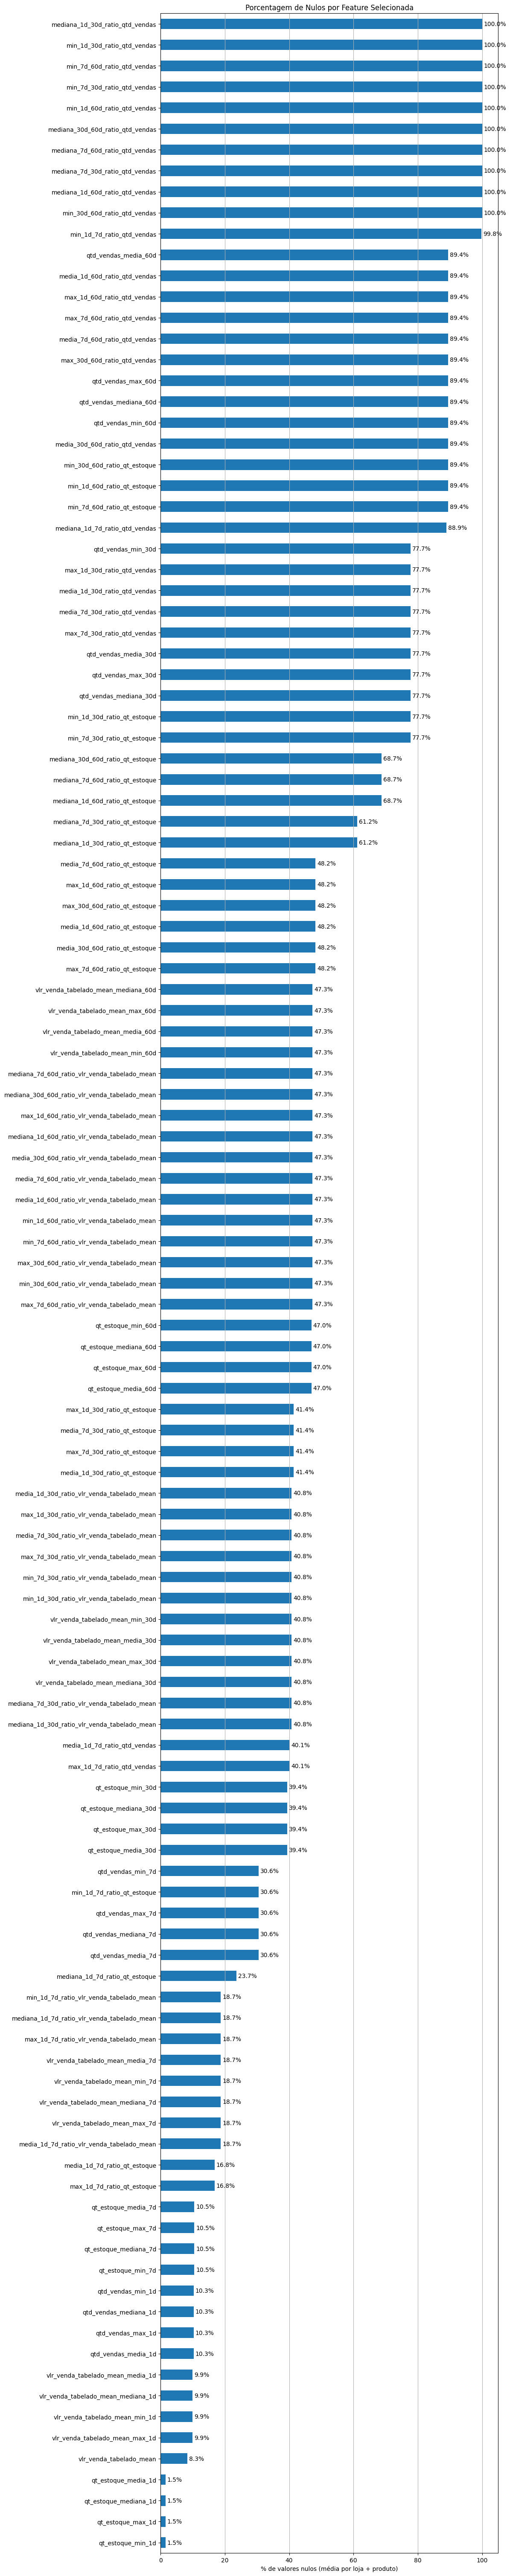

In [8]:
df_percent_nulos_por_feature = validate_features_null(df, list_feat_num)

In [9]:
list_feat_remove_null_num = df_percent_nulos_por_feature[df_percent_nulos_por_feature['perct_nulo']>=50]['index'].values
list_feat_remove_null_num

array(['mediana_1d_30d_ratio_qtd_vendas', 'min_1d_30d_ratio_qtd_vendas',
       'min_7d_60d_ratio_qtd_vendas', 'min_7d_30d_ratio_qtd_vendas',
       'min_1d_60d_ratio_qtd_vendas', 'mediana_30d_60d_ratio_qtd_vendas',
       'mediana_7d_60d_ratio_qtd_vendas',
       'mediana_7d_30d_ratio_qtd_vendas',
       'mediana_1d_60d_ratio_qtd_vendas', 'min_30d_60d_ratio_qtd_vendas',
       'min_1d_7d_ratio_qtd_vendas', 'qtd_vendas_media_60d',
       'media_1d_60d_ratio_qtd_vendas', 'max_1d_60d_ratio_qtd_vendas',
       'max_7d_60d_ratio_qtd_vendas', 'media_7d_60d_ratio_qtd_vendas',
       'max_30d_60d_ratio_qtd_vendas', 'qtd_vendas_max_60d',
       'qtd_vendas_mediana_60d', 'qtd_vendas_min_60d',
       'media_30d_60d_ratio_qtd_vendas', 'min_30d_60d_ratio_qt_estoque',
       'min_1d_60d_ratio_qt_estoque', 'min_7d_60d_ratio_qt_estoque',
       'mediana_1d_7d_ratio_qtd_vendas', 'qtd_vendas_min_30d',
       'max_1d_30d_ratio_qtd_vendas', 'media_1d_30d_ratio_qtd_vendas',
       'media_7d_30d_ratio_qtd_

- Nenhuma Feature Categórica estava como nula

In [10]:
df_train.drop(columns=list_feat_remove_null_num,inplace=True)
df_test.drop(columns=list_feat_remove_null_num,inplace=True)

In [11]:
list_feat_num = list(set(list_feat_num)-set(list_feat_remove_null_num))

In [12]:
df[list_feat_cat].isnull().sum()

des_estado_franquia      0
categoria_produto        0
sub_categoria_produto    0
linha_produto            0
day_of_the_week          0
key_loja                 0
cod_produto              0
dtype: int64

- Não vou fazer tratamento de valores nulos, pois irei utilizar o modelo Catboost que aceita valores NaN, qualquer tratamento que eu fizer pode gerar viés

# Validando Distribuição

In [13]:
def identify_outliers(df, list_feat):
    outlier_porcentagens = {f: [] for f in list_feat}

    # Agrupa por loja + produto
    for (loja, produto), grupo in df.groupby(['key_loja', 'cod_produto']):
        for feature in list_feat:
            serie = grupo[feature].dropna()
            if len(serie) < 2:
                continue
    
            q1 = serie.quantile(0.25)
            q3 = serie.quantile(0.75)
            iqr = q3 - q1
            lim_inf = q1 - 1.5 * iqr
            lim_sup = q3 + 1.5 * iqr
    
            qtd_outliers = ((serie < lim_inf) | (serie > lim_sup)).sum()
            perc_outliers = (qtd_outliers / len(serie)) * 100
            outlier_porcentagens[feature].append(perc_outliers)
    
    # Calcula mediana por feature
    mediana_outliers_por_feature = {
        f: pd.Series(vals).median() if len(vals) > 0 else 0
        for f, vals in outlier_porcentagens.items()
    }
    
    # Converte em DataFrame
    df_outliers_por_grupo = pd.DataFrame.from_dict(
        mediana_outliers_por_feature, orient='index', columns=['perct_mediana_outliers']
    ).sort_values(by='perct_mediana_outliers', ascending=False)
    
    df_outliers_por_grupo.reset_index(inplace=True)

    return df_outliers_por_grupo

In [14]:
df_outliers_por_grupo = identify_outliers(df_train, list_feat_num)

In [15]:
df_outliers_por_grupo[df_outliers_por_grupo['perct_mediana_outliers']>=15]

,index,perct_mediana_outliers
0,media_1d_7d_ratio_vlr_venda_tabelado_mean,24.945887
1,mediana_30d_60d_ratio_vlr_venda_tabelado_mean,20.000000
2,min_7d_30d_ratio_vlr_venda_tabelado_mean,20.000000
3,qtd_vendas_max_7d,18.100000
4,vlr_venda_tabelado_mean_mediana_30d,16.969697
5,qtd_vendas_mediana_7d,15.972222


- Para todas as features que apresentam porcentagem média de outliers >= 15% irei avaliar suas importancias para o modelo, pois como vou utilizar CatBoost que é um modelo de arvore ele tende a ser robusto com outliers
- Caso essas features mostrem-se importantes posso realizar tratamentos e avaliar se ocorre uma melhora no modelo

# Avaliação Importancia das Features

## Categóricas

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def create_grid_barplots(df, cols_categoricas, col_y, n_cols=5):
    n = len(cols_categoricas)
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols_categoricas):
        ax = axes[i]
        # Agrupa e ordena decrescentemente
        df_aux = df.groupby(col)[col_y].sum().reset_index().sort_values(by=col_y, ascending=False)
        
        sns.barplot(x=col, y=col_y, data=df_aux, ax=ax, order=df_aux[col])
        # ax.set_title(f"{col} x {col_y}")
        ax.set_xlabel(col)
        ax.set_ylabel(col_y)

        # Adiciona os valores sobre as barras
        for bar, value in zip(ax.patches, df_aux[col_y]):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 2),
                    ha='center', va='bottom', color='black', fontsize=9)

        ax.tick_params(axis='x', rotation=45)

    # Remove gráficos extras (caso n < n_rows * n_cols)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

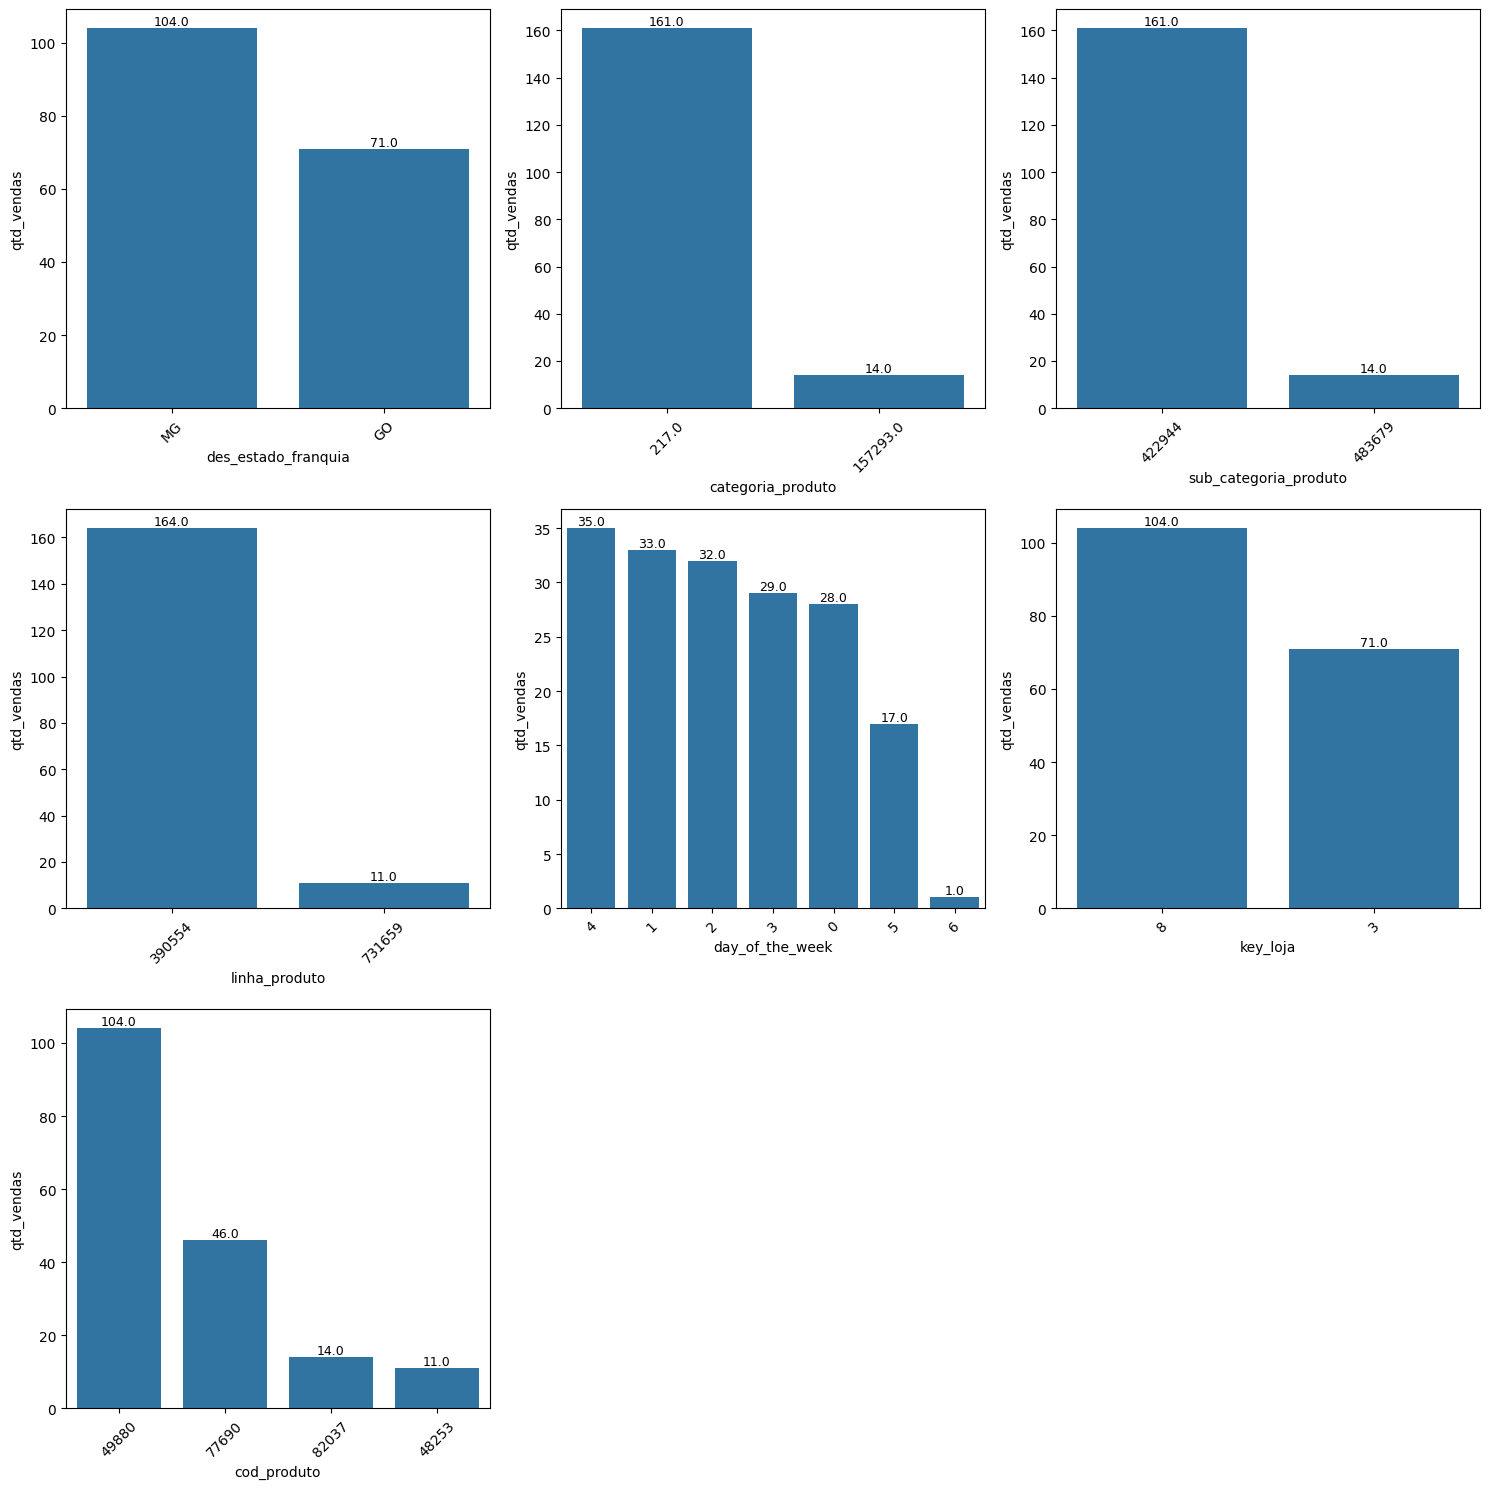

In [19]:
# cols_categoricas = ['categoria_produto', 'sub_categoria_produto', 'linha_produto', 'regiao', 'tipo_loja', ...]  # até 10 colunas
create_grid_barplots(df_train, list_feat_cat, 'qtd_vendas', n_cols=3)

In [30]:
def avaliar_categorica_kruskal(df, col_categ, col_y):
    grupos = df[[col_categ, col_y]].dropna().groupby(col_categ)[col_y].apply(list)

    if len(grupos) < 2:
        return None, None  # Não tem comparação válida

    try:
        stat, pvalue = kruskal(*grupos)
        return stat, pvalue
    except Exception as e:
        print(f"Erro em {col_categ}: {e}")
        return None, None

In [31]:
resultados_cat = []

for col in list_feat_cat:  # ex: ['tipo_loja', 'categoria_produto']
    stat, p = avaliar_categorica_kruskal(df_train, col, 'qtd_vendas')
    if stat is not None:
        decisao = 'RELEVANTE' if p < 0.05 else 'DESCARTAR'
        resultados_cat.append((col, stat, p, decisao))

# Salvar em DataFrame
df_resultados_cat = pd.DataFrame(resultados_cat, columns=['feature', 'stat_H', 'p_value', 'decisao'])
df_resultados_cat

,feature,stat_H,p_value,decisao
0,des_estado_franquia,0.707186,0.400379,DESCARTAR
1,categoria_produto,0.575309,0.448157,DESCARTAR
2,sub_categoria_produto,0.575309,0.448157,DESCARTAR
3,linha_produto,0.004299,0.947721,DESCARTAR
4,day_of_the_week,34.751373,0.000005,RELEVANTE
5,key_loja,0.707186,0.400379,DESCARTAR
6,cod_produto,0.942426,0.815179,DESCARTAR


## Numéricas

In [32]:
def classificar_percentil(df, list_features_num):
    df_copy = df.copy()
    colunas_sucesso = []
    colunas_falhas = []
    
    percentis = [0.05, 0.25, 0.5, 0.75, 0.95]
    rotulos = ['P05', 'P25', 'P50', 'P75', 'P95']
    
    for col in list_features_num:
        try:
            limites = df[col].quantile(percentis).values
            bins = [-np.inf] + list(limites) + [np.inf]
            labels = rotulos + ['>P95']
            df_copy[f'{col}_percentil'] = pd.cut(
                df[col], bins=bins, labels=labels, include_lowest=True, duplicates='drop'
            )
            colunas_sucesso.append(f'{col}_percentil')
        except ValueError as e:
            colunas_falhas = [].append(col)
            print(f"⚠️ Erro ao classificar '{col}': {e}")

    return df_copy, colunas_sucesso, colunas_falhas

In [33]:
def agrupar_extremos_percentil(df, cols_percentil):
    df_copy = df.copy()
    for col in cols_percentil:
        if '>P95' in df_copy[col].unique():
            df_copy[col] = df_copy[col].replace('>P95', 'P95')
    return df_copy

In [34]:
def identificar_features_nao_ordenadas(df, cols_percentil, col_y='qtd_vendas'):
    features_nao_ordenadas = []

    for col in cols_percentil:
        # Calcula a média de vendas por grupo de percentil
        medias = df.groupby(col)[col_y].mean().dropna()
        valores = medias.values

        # Verifica se está ordenado (crescente ou decrescente)
        if not (np.all(np.diff(valores) >= 0) or np.all(np.diff(valores) <= 0)):
            features_nao_ordenadas.append(col)

    return features_nao_ordenadas

In [35]:
df_com_percentis, colunas_sucesso, colunas_falhas = classificar_percentil(df_train, list_feat_num)
df_com_percentis

⚠️ Erro ao classificar 'max_30d_60d_ratio_vlr_venda_tabelado_mean': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'vlr_venda_tabelado_mean': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'qtd_vendas_media_1d': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'min_7d_60d_ratio_vlr_venda_tabelado_mean': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'vlr_venda_tabelado_mean_min_1d': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'min_1d_7d_ratio_vlr_venda_tabelado_mean': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'max_7d_30d_ratio_vlr_venda_tabelado_mean': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'min_1d_30d_ratio_vlr_venda_tabelado_mean': Bin labels must be one fewer than the number of bin edges
⚠️ Erro ao classificar 'media_1d_7d_ratio_vlr_ve

,key_loja,cod_produto,dt_estoque,qtd_vendas,des_estado_franquia,categoria_produto,sub_categoria_produto,linha_produto,vlr_venda_tabelado_mean,qtd_vendas_media_1d,...,qt_estoque_mediana_1d_percentil,qt_estoque_max_60d_percentil,qt_estoque_media_7d_percentil,qt_estoque_mediana_7d_percentil,vlr_venda_tabelado_mean_max_60d_percentil,qt_estoque_min_1d_percentil,media_7d_30d_ratio_qt_estoque_percentil,qtd_vendas_media_7d_percentil,vlr_venda_tabelado_mean_media_60d_percentil,media_1d_7d_ratio_qt_estoque_percentil
0,3,48253,2024-01-01,0.0,GO,217.0,422944,731659,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,77690,2024-01-01,0.0,GO,217.0,422944,390554,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,82037,2024-01-01,0.0,GO,157293.0,483679,390554,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,48253,2024-01-02,0.0,GO,217.0,422944,731659,NaN,0.0,...,P75,NaN,NaN,NaN,NaN,P75,NaN,NaN,NaN,NaN
4,3,77690,2024-01-02,1.0,GO,217.0,422944,390554,377.4,0.0,...,P75,NaN,NaN,NaN,NaN,P75,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,8,49880,2024-12-26,0.0,MG,217.0,422944,390554,149.7,0.0,...,P50,P95,P75,P50,P50,P50,P75,P95,P50,P25
426,8,49880,2024-12-27,2.0,MG,217.0,422944,390554,149.7,0.0,...,P50,P95,P50,P50,P50,P50,P50,P95,P50,P25
427,8,49880,2024-12-28,0.0,MG,217.0,422944,390554,149.7,2.0,...,P50,P95,P50,P50,P50,P50,P50,P95,P50,P50
429,8,49880,2024-12-30,1.0,MG,217.0,422944,390554,748.5,0.0,...,P75,P95,P50,P50,P50,P75,P50,P75,P50,P95


In [40]:
#df_percentil_agrupado = agrupar_extremos_percentil(df_com_percentis, colunas_sucesso)
#df_percentil_agrupado
# 2. Identificar features não ordenadas
#features_nao_ordenadas = identificar_features_nao_ordenadas(df_percentil_agrupado, colunas_sucesso)

#print("Features que NÃO ordenam 'qtd_vendas':")
#print(features_nao_ordenadas)

In [41]:
#colunas_sucesso_ordem = list(set(colunas_sucesso)-set(features_nao_ordenadas))
#colunas_sucesso_ordem

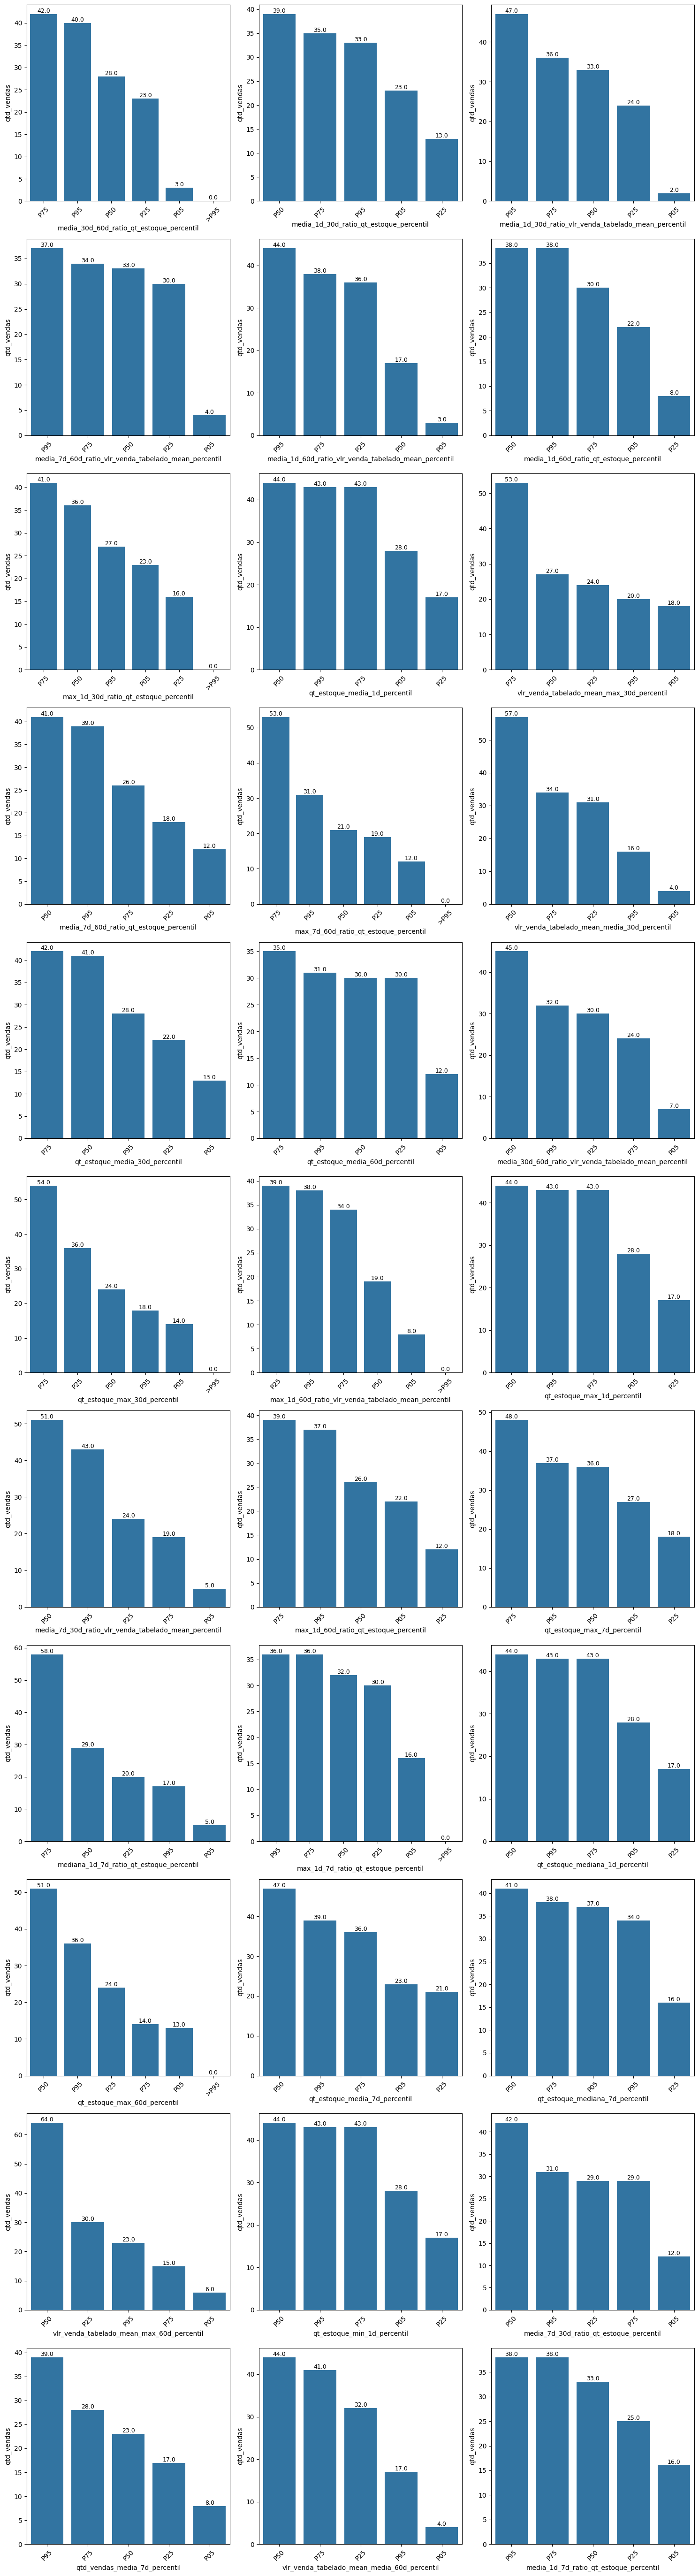

In [39]:
create_grid_barplots(df_percentil_agrupado, colunas_sucesso, 'qtd_vendas', n_cols=3)

In [42]:
def avaliar_feature_percentil_kruskal(df, col_percentil, col_y):
    # Agrupa por categoria da feature (ex: P05, P25, ...)
    grupos = df[[col_percentil, col_y]].dropna().groupby(col_percentil)[col_y].apply(list)
    
    if len(grupos) < 2:
        return None, None  # Não dá para testar com < 2 grupos

    # Aplica o teste de Kruskal-Wallis
    stat, pvalue = kruskal(*grupos)
    return stat, pvalue

In [44]:
resultados = []

for col in colunas_sucesso:  # ex: ['preco_percentil', 'estoque_percentil']
    stat, p = avaliar_feature_percentil_kruskal(df_com_percentis, col, 'qtd_vendas')
    if stat is not None:
        resultados.append((col, stat, p, 'RELEVANTE' if p < 0.05 else 'DESCARTAR'))

# Ordenar por p-valor
resultados = sorted(resultados, key=lambda x: x[2])

df_resultados = pd.DataFrame(resultados, columns=['feature', 'stat_H', 'p_value', 'decisao'])

# Exibir
df_resultados[df_resultados['decisao'] == 'DESCARTAR']

# # Filtrar apenas features relevantes
# df_relevantes = df_resultados[df_resultados['decisao'] == 'RELEVANTE']
# features_relevantes = df_relevantes['feature'].tolist()

# # Mostrar
# for col, stat, p, decisao in resultados:
#     print(f"{col}: H={stat:.2f}, p-valor={p:.4f} --> {decisao}")

,feature,stat_H,p_value,decisao
0,media_30d_60d_ratio_qt_estoque_percentil,NaN,NaN,DESCARTAR
17,vlr_venda_tabelado_mean_max_30d_percentil,10.236505,0.068805,DESCARTAR
18,vlr_venda_tabelado_mean_media_30d_percentil,9.561603,0.088654,DESCARTAR
19,media_30d_60d_ratio_vlr_venda_tabelado_mean_pe...,9.333163,0.096491,DESCARTAR
20,media_1d_30d_ratio_vlr_venda_tabelado_mean_per...,8.158383,0.147720,DESCARTAR
21,media_7d_60d_ratio_vlr_venda_tabelado_mean_per...,3.435709,0.633137,DESCARTAR
22,max_1d_30d_ratio_qt_estoque_percentil,NaN,NaN,DESCARTAR
23,max_7d_60d_ratio_qt_estoque_percentil,NaN,NaN,DESCARTAR
24,qt_estoque_max_30d_percentil,NaN,NaN,DESCARTAR
25,max_1d_60d_ratio_vlr_venda_tabelado_mean_perce...,NaN,NaN,DESCARTAR


## Feature Selection por Modelo

In [48]:
from catboost import CatBoostRegressor, Pool
import pandas as pd

def selecionar_features_por_importancia(X, y, cat_features=None, top_k=None, threshold=None):
    model = CatBoostRegressor(
        verbose=0,
        random_state=42,
        cat_features=cat_features
    )
    model.fit(X, y)

    # Importâncias
    importancias = model.get_feature_importance(prettified=True)
    importancias.columns = ['feature', 'importance']
    importancias = importancias.sort_values(by='importance', ascending=False)

    # Seleção por top_k
    if top_k:
        selecionadas = importancias.head(top_k)['feature'].tolist()
    elif threshold:
        selecionadas = importancias[importancias['importance'] >= threshold]['feature'].tolist()
    else:
        selecionadas = importancias[importancias['importance'] > 0]['feature'].tolist()

    return selecionadas, importancias


In [51]:
list_feat = list_feat_cat.copy()
list_feat.extend(list_feat_num)
list_feat = list(set(list_feat))
list_feat

['max_30d_60d_ratio_vlr_venda_tabelado_mean',
 'media_30d_60d_ratio_qt_estoque',
 'qtd_vendas_media_1d',
 'vlr_venda_tabelado_mean',
 'min_7d_60d_ratio_vlr_venda_tabelado_mean',
 'media_1d_30d_ratio_qt_estoque',
 'vlr_venda_tabelado_mean_min_1d',
 'cod_produto',
 'categoria_produto',
 'min_1d_7d_ratio_vlr_venda_tabelado_mean',
 'day_of_the_week',
 'max_7d_30d_ratio_vlr_venda_tabelado_mean',
 'min_1d_30d_ratio_vlr_venda_tabelado_mean',
 'media_1d_7d_ratio_vlr_venda_tabelado_mean',
 'mediana_1d_7d_ratio_vlr_venda_tabelado_mean',
 'max_30d_60d_ratio_qt_estoque',
 'mediana_1d_30d_ratio_vlr_venda_tabelado_mean',
 'vlr_venda_tabelado_mean_max_7d',
 'media_1d_30d_ratio_vlr_venda_tabelado_mean',
 'qt_estoque_min_60d',
 'max_1d_30d_ratio_vlr_venda_tabelado_mean',
 'media_7d_60d_ratio_vlr_venda_tabelado_mean',
 'media_1d_60d_ratio_vlr_venda_tabelado_mean',
 'min_1d_60d_ratio_vlr_venda_tabelado_mean',
 'qtd_vendas_mediana_1d',
 'media_1d_60d_ratio_qt_estoque',
 'max_1d_30d_ratio_qt_estoque',
 'qt

In [53]:
X = df_train[list_feat]
X

,max_30d_60d_ratio_vlr_venda_tabelado_mean,media_30d_60d_ratio_qt_estoque,qtd_vendas_media_1d,vlr_venda_tabelado_mean,min_7d_60d_ratio_vlr_venda_tabelado_mean,media_1d_30d_ratio_qt_estoque,vlr_venda_tabelado_mean_min_1d,cod_produto,categoria_produto,min_1d_7d_ratio_vlr_venda_tabelado_mean,...,vlr_venda_tabelado_mean_media_1d,qtd_vendas_media_7d,vlr_venda_tabelado_mean_mediana_1d,vlr_venda_tabelado_mean_media_60d,qtd_vendas_min_1d,min_1d_7d_ratio_qt_estoque,qtd_vendas_mediana_7d,media_1d_7d_ratio_qt_estoque,vlr_venda_tabelado_mean_min_30d,qtd_vendas_max_7d
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48253,217.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77690,217.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82037,157293.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,48253,217.0,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.0,377.4,NaN,NaN,NaN,77690,217.0,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,1.0,1.985560,0.0,149.7,1.0,0.872727,149.7,49880,217.0,1.0,...,149.7,1.000000,149.7,172.362917,0.0,1.000,1.0,0.682927,149.7,3.0
426,1.0,1.992958,0.0,149.7,1.0,0.848057,149.7,49880,217.0,1.0,...,149.7,0.857143,149.7,172.362917,0.0,1.000,1.0,0.777778,149.7,3.0
427,1.0,2.000000,2.0,149.7,1.0,0.824742,149.7,49880,217.0,1.0,...,149.7,1.000000,149.7,172.362917,2.0,1.000,1.0,0.861538,149.7,3.0
429,1.0,1.943218,0.0,748.5,1.0,1.266234,149.7,49880,217.0,1.0,...,149.7,0.428571,149.7,172.362917,0.0,1.625,0.0,1.358209,149.7,2.0


In [55]:
list_feat_cat

['des_estado_franquia',
 'categoria_produto',
 'sub_categoria_produto',
 'linha_produto',
 'day_of_the_week',
 'key_loja',
 'cod_produto']

In [54]:
# Separar X e y
X = df_train[list_feat]
y = df_train['qtd_vendas']

# # Executar seleção
features_boas, ranking = selecionar_features_por_importancia(X, y, cat_features=list_feat_cat)

print("Features selecionadas:", features_boas)
print("\nRanking completo:")
print(ranking)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=8]=217.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

# Treinamento Modelo

## Tunnig

In [ ]:
# def smape(y_true, y_pred):
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     denominator = (np.abs(y_true) + np.abs(y_pred)) + 1e-8
#     return 100 * np.mean(2 * np.abs(y_pred - y_true) / denominator)

In [ ]:
# def objective(trial, X, y, cat_features, mae_baseline):
#     from catboost import CatBoostRegressor, Pool
#     from sklearn.model_selection import KFold
#     import numpy as np

#     params = {
#         'loss_function': 'MAE',
#         'iterations': trial.suggest_int('iterations', 300, 700),
#         'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1),
#         'depth': trial.suggest_int('depth', 4, 7),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3, 9),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.2, 1.0),
#         'random_strength': trial.suggest_float('random_strength', 1, 5),
#         'early_stopping_rounds': 50,
#         'verbose': 0,
#         'random_seed': 42
#     }

#     model = CatBoostRegressor(**params)
#     cv = KFold(n_splits=3, shuffle=True, random_state=42)
#     maes = []

#     for train_idx, valid_idx in cv.split(X):
#         X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#         y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

#         train_pool = Pool(X_train, y_train, cat_features=cat_features)
#         valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

#         model.fit(train_pool, eval_set=valid_pool)
#         preds = model.predict(valid_pool)
#         mae = np.mean(np.abs(y_valid - preds))
#         maes.append(mae)

#     mean_mae = np.mean(maes)

#     # Penalização: queremos a maior diferença positiva do baseline
#     if mean_mae >= mae_baseline:
#         penalty = (mean_mae - mae_baseline) * 10  # penaliza fortemente se for pior
#     else:
#         penalty = 0  # não penaliza se for melhor

#     return mean_mae + penalty  # ainda minimizamos, mas com punição extra


In [ ]:
# # No treino: calcula a mediana por grupo
# mediana_por_grupo = X_train.join(y_train).groupby(['key_loja', 'cod_produto'])['qtd_vendas'].median()

# # No teste: aplica a mediana como previsão
# y_pred = X_test.set_index(['key_loja', 'cod_produto']).index.map(mediana_por_grupo).fillna(y_train.median())

# from sklearn.metrics import mean_absolute_error

# mae_baseline = mean_absolute_error(y_test, y_pred)
# print(f"MAE do baseline (mediana loja+produto): {mae_baseline:.2f}")


In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

def objective(trial, X, y, cat_features):
    params = {
        'loss_function': 'MAE',
        'iterations': trial.suggest_int('iterations', 300, 700),  # menos árvores, já converge bem
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1),  # evita learning_rate muito baixo
        'depth': trial.suggest_int('depth', 4, 7),  # complexidade controlada
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3, 9),  # regularização moderada
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.2, 1.0),  # controle de amostragem
        'random_strength': trial.suggest_float('random_strength', 1, 5),  # ruído nos splits
        'early_stopping_rounds': 50, 
        'verbose': 0,
        'random_seed': 42
    }

    model = CatBoostRegressor(**params)

    # Validação cruzada com MAE
    model = CatBoostRegressor(**params)
    cv = KFold(n_splits=3, shuffle=True, random_state=42)

    maes = []
    for train_idx, valid_idx in cv.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        train_pool = Pool(X_train, y_train, cat_features=cat_features)
        valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

        model.fit(train_pool, eval_set=valid_pool)
        preds = model.predict(valid_pool)
        mae = np.mean(np.abs(y_valid - preds))
        maes.append(mae)

    return np.mean(maes)

def rodar_otimizacao_bayesiana(X, y, cat_features, n_trials=50):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, cat_features), n_trials=n_trials)

    return study.best_trial, study.best_params, study

In [ ]:
X = df_train[list_feat]
y = df_train['qtd_vendas']

In [ ]:
# Rode a otimização bayesiana
best_trial, best_params, study = rodar_otimizacao_bayesiana(X, y, list_feat_cat, n_trials=5)

print("Melhores hiperparâmetros encontrados:")
print(best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study).show()

In [ ]:
optuna.visualization.plot_param_importances(study).show()

In [ ]:
optuna.visualization.plot_slice(study).show()